In [2]:
import pandas as pd
import pickle as pkl
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from ast import literal_eval
import seaborn as sns
from scipy import stats
import torch

import sys
sys.path.append('/work/magroup/kaileyhu/synthetic_lethality')

In [3]:
with open ("/work/magroup/kaileyhu/res/ablations/cv1/gene2vec_UQ_NONE_5_fold_0.1_calib.pkl", "rb") as f: #_tester
    regular_uq = pkl.load(f)

In [4]:
regular_uq.keys()

dict_keys(['uncertainty_quantification', 'mondrian_pred_vals', 'mondrian_corr', 'mondrian_conf_scores', 'mondrian_test_names', 'mondrian_probs_list', 'calibration_scores'])

In [5]:
Counter(regular_uq['mondrian_corr'][0])

Counter({1: 877108, 0: 125366})

In [6]:
calib_scores = regular_uq['calibration_scores']

In [7]:
with open("/work/magroup/kaileyhu/res/UQ/Mondrian_by_tissue_NSM_EXP_5x.pkl", "rb") as f:
    mondrian_class_dict = pkl.load(f)

def extract_name(x):
    return x["patient"]

def get_df(uq):
    test_names = uq['mondrian_test_names']
    patient_names = [list(map(lambda x : x.split(',')[0][1:], list(test_names[i].index))) for i in range(len(test_names))]
    test_names = [test_names[i][['gene 1', 'gene 2']] for i in range(len(test_names))]
    
    corr = uq['mondrian_corr']
    pred_vals = uq['mondrian_pred_vals']
    
    conf_scores = uq['mondrian_conf_scores']
    conf_scores = [item for sublist in conf_scores for item in sublist]
    conf_scores_high = [x[0] for x in conf_scores]
    conf_scores_low = [x[1] for x in conf_scores]
    
    fold_list = [[fold for i in range(len(corr[fold]))] for fold in range(len(corr))]
    
    test_genes_1 = [list(test_names[fold]['gene 1']) for fold in range(len(corr))]
    test_genes_2 = [list(test_names[fold]['gene 2']) for fold in range(len(corr))]
    test_genes_1 = [item for sublist in test_genes_1 for item in sublist]
    test_genes_2 = [item for sublist in test_genes_2 for item in sublist]
    
    corr = [item for sublist in corr for item in sublist]
    pred_vals = [item for sublist in pred_vals for item in sublist]
    fold_list = [item for sublist in fold_list for item in sublist]
    patient_names = [item for sublist in patient_names for item in sublist]
    
    uq_df = pd.DataFrame({'gene 1': test_genes_1, 'gene 2' : test_genes_2, 'label' : corr, 'pred' : pred_vals, 'conf high' : conf_scores_high, 'conf low' : conf_scores_low, 'fold' : fold_list, 'patient' : patient_names})
    uq_df['conf high'] = uq_df['conf high'].apply(lambda x : round(x, 3)) 
    uq_df['conf low'] = uq_df['conf low'].apply(lambda x : round(x, 3)) 
    
    uq_df['correct'] = uq_df.apply(lambda row : row['label'] == row['pred'], axis = 1)

    uq_df['tissue'] = uq_df['patient'].apply(lambda x : mondrian_class_dict[x])
    uq_df['tissue'] = uq_df['tissue'].apply(lambda x : str(x).lower())
    return uq_df

In [8]:
reg_df = get_df(regular_uq)

In [7]:
def plot_coverage(reg_df, title):
    plt.figure(figsize=(8, 6))
    
    alphas = np.linspace(0.00, 0.5, 100)
    target_confidence = 1 - alphas

    coverage_rates = []
    for alpha in alphas:
        is_covered = reg_df['conf high'] >= alpha
        empirical_coverage = is_covered.mean()
        coverage_rates.append(empirical_coverage)
    
    plt.plot(target_confidence, coverage_rates, label='Conformal prediction', linestyle='-', color="#2A9D8F", linewidth = 2) 
    
    plt.plot([0.5, 1.0], [0.5, 1.0], '--', label='y = x', color="#E76F51", linewidth = 2) 
    
    plt.xlabel('Expected coverage', fontsize=14)
    plt.ylabel('Empirical coverage', fontsize=14)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    # plt.show()
    plt.savefig("figs_to_use/coverage.pdf")

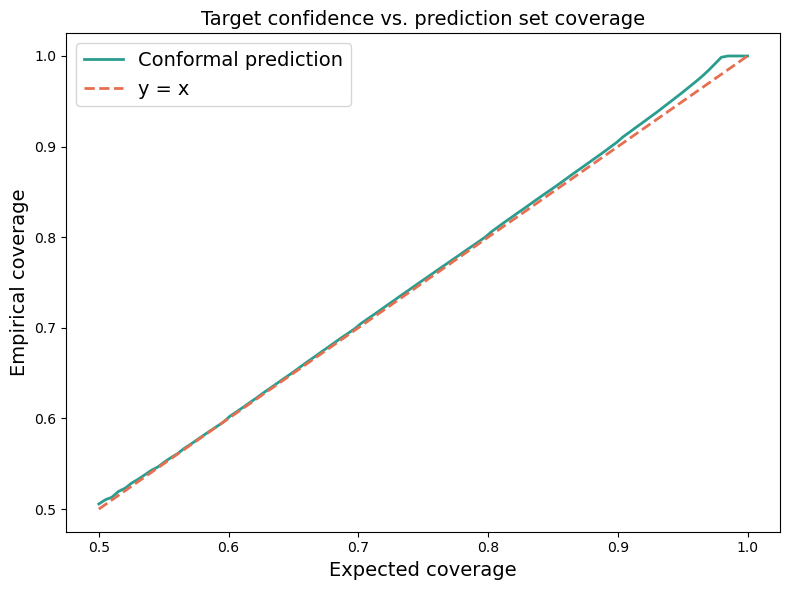

In [23]:
plot_coverage( reg_df, "Target confidence vs. prediction set coverage")

In [9]:
def _qhat(scores, alpha):
    """
    Exact finite-sample conformal quantile:
    order statistic at k = ceil((n+1)*(1-alpha)), clamped to [1, n].
    """
    s = np.sort(np.asarray(scores, dtype=float))
    n = s.size
    if n == 0:
        return 1.0  # maximally conservative if empty
    k = int(np.ceil((n + 1) * (1.0 - alpha)))
    k = min(max(k, 1), n)
    return s[k - 1]

In [ ]:
np.mean(pred_probs_len)

In [8]:
big_probs_list = regular_uq['mondrian_probs_list']

In [9]:
big_probs_list = [[x.cpu().tolist() for x in pred_probs] for pred_probs in big_probs_list]

In [90]:
def mean_set_size(reg_df, title):
    plt.figure(figsize=(8, 6))
    
    alphas = np.linspace(0.0, 0.1, 100)
    target_confidence = 1 - alphas

    set_sizes = []
    for alpha in tqdm(alphas):
        pred_probs_len = []
        for fold in range(5):
            fold_df = reg_df[reg_df['fold'] == fold]
            pred_probs = big_probs_list[fold]

            qhat = _qhat(calib_scores[fold][-1], alpha)
            pred_probs_len += [len([i for i in x if i >= 1 - qhat]) for x in pred_probs]
            pred_probs_len = [i for i in pred_probs_len if i > 0]
            
        set_sizes.append(np.mean(pred_probs_len))
    plt.xlim(0.9, 1.0)
    
    plt.plot(target_confidence, set_sizes, label='Conformal prediction', linestyle='-', color="#2A9D8F", linewidth = 2) 
    
    plt.xlabel('Target coverage (1 - alpha)', fontsize=14)
    plt.ylabel('Mean set size', fontsize=14)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    # plt.show()
    plt.savefig("figs_to_use/mean_set_size.pdf")
    return target_confidence, set_sizes

100%|██████████| 100/100 [07:26<00:00,  4.47s/it]


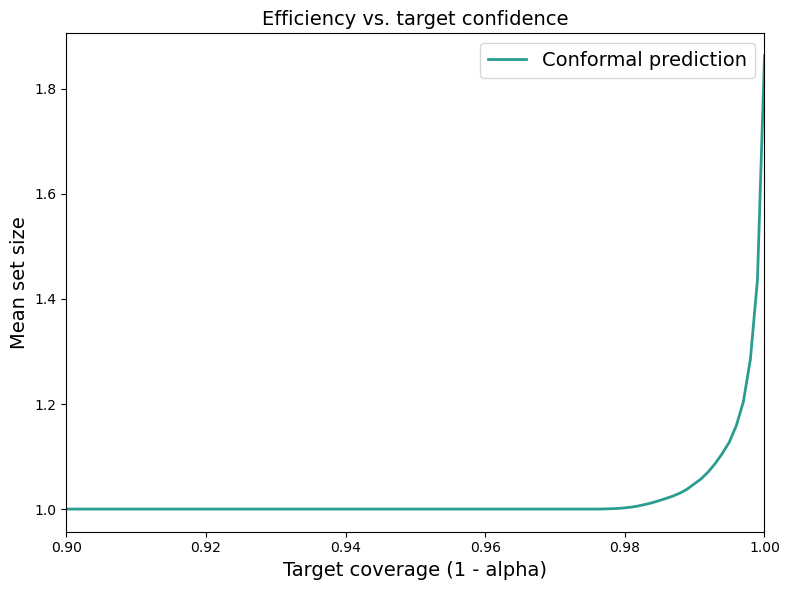

In [91]:
target_confidence, set_sizes = mean_set_size(reg_df, "Efficiency vs. target confidence")

In [17]:
SL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_SL.csv")
nonSL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_nonSL.csv")

In [18]:
SL_df['gene_pairs'] = SL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)
nonSL_df['gene_pairs'] = nonSL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)
pair_to_source = SL_df.set_index('gene_pairs')['r.source'].to_dict()
pair_to_source = pair_to_source | nonSL_df.set_index('gene_pairs')['r.source'].to_dict()

In [19]:
def query_dict(x):
    if x in pair_to_source:
        return pair_to_source[x]
    x_rev = (x[1], x[0])
    if x_rev in pair_to_source:
        return pair_to_source[x_rev]
    else:
        return 'Negative sampling'

In [20]:
reg_df['gene_pairs'] = reg_df.apply(lambda row : (row['gene 1'], row['gene 2']), axis = 1)
reg_df['source'] = reg_df['gene_pairs'].apply(query_dict)

In [21]:
sources = set(reg_df['source'])

In [15]:
reg_df

,gene 1,gene 2,label,pred,conf high,conf low,fold,patient,correct,tissue,gene_pairs,source
0,FKBP11,SLC22A1,0,0,0.330,0.002,0,ACH-001370,True,ovary,"(FKBP11, SLC22A1)",GenomeRNAi
1,FKBP11,SLC22A1,0,0,0.317,0.002,0,ACH-000305,True,lymph_node,"(FKBP11, SLC22A1)",GenomeRNAi
2,SMURF2,TP53,0,1,1.000,0.001,0,ACH-000836,False,salivary_gland,"(SMURF2, TP53)",Computational Prediction
3,SMURF2,TP53,0,1,0.477,0.001,0,ACH-001001,False,bone,"(SMURF2, TP53)",Computational Prediction
4,SMURF2,TP53,0,1,0.566,0.001,0,ACH-000896,False,urinary_tract,"(SMURF2, TP53)",Computational Prediction
...,...,...,...,...,...,...,...,...,...,...,...,...
4950103,AMPD2,LAD1,0,0,0.062,0.006,4,ACH-000778,True,upper_aerodigestive_tract,"(AMPD2, LAD1)",Negative sampling
4950104,AMPD2,LAD1,0,0,0.058,0.006,4,ACH-000118,True,ascites,"(AMPD2, LAD1)",Negative sampling
4950105,AMPD2,LAD1,0,0,0.100,0.004,4,ACH-000794,True,lymph_node,"(AMPD2, LAD1)",Negative sampling
4950106,AMPD2,LAD1,0,0,0.084,0.005,4,ACH-000865,True,oesophagus,"(AMPD2, LAD1)",Negative sampling


In [22]:
target_confs = np.linspace(0.00, 1.0, 20)
source_dict = {s : [] for s in sources}

for c in tqdm(target_confs):
    is_covered = reg_df[reg_df['conf high'] >= c]
    for s in sources:
        temp = is_covered[is_covered['source'] == s]
        source_dict[s].append(len(temp))

100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


In [25]:
source_dict.keys()

dict_keys(['Decipher', 'GenomeRNAi;Text Mining', 'Synlethality;Text Mining', 'Synlethality', 'Low Throughput', 'GenomeRNAi', 'Synlethality;Decipher', 'RNAi Screen', 'Drug Screen', 'Decipher;Text Mining', 'Text Mining;Synlethality', 'Text Mining', 'CRISPR/CRISPRi', 'Computational Prediction', 'High Throughput', 'Negative sampling'])

In [29]:
for s in source_dict:
    source_dict[s] = 1 / max(source_dict[s]) * np.array(source_dict[s])

In [52]:
source_dict.keys()

dict_keys(['Decipher', 'GenomeRNAi;Text Mining', 'Synlethality;Text Mining', 'Synlethality', 'Low Throughput', 'GenomeRNAi', 'Synlethality;Decipher', 'RNAi Screen', 'Drug Screen', 'Decipher;Text Mining', 'Text Mining;Synlethality', 'Text Mining', 'CRISPR/CRISPRi', 'Computational Prediction', 'High Throughput', 'Negative sampling'])

In [54]:
source_dict['Negative sampling'][-1]

0.1333638259977685

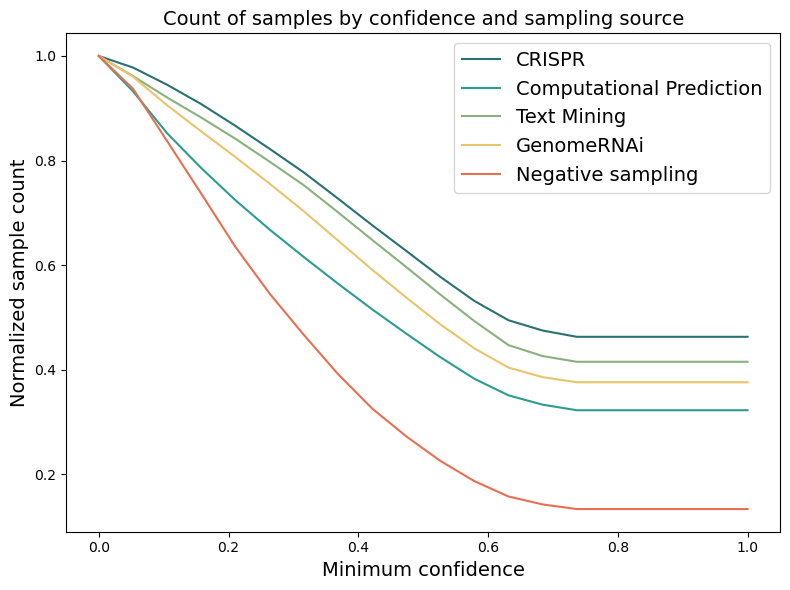

In [85]:
plt.figure(figsize=(8, 6))
plt.plot(target_confs, source_dict['CRISPR/CRISPRi'], color="#287271", label = "CRISPR") 
plt.plot(target_confs, source_dict['Computational Prediction'], color="#2A9D8F", label = "Computational Prediction") 
plt.plot(target_confs, source_dict['Text Mining'], color = "#8AB17D", label = "Text Mining") 
plt.plot(target_confs, source_dict['GenomeRNAi'], color = "#E9C46A", label = "GenomeRNAi") 
plt.plot(target_confs, source_dict['Negative sampling'], color = "#E76F51", label = "Negative sampling") 


plt.xlabel('Minimum confidence', fontsize=14)
plt.ylabel('Normalized sample count', fontsize=14)
plt.title("Count of samples by confidence and sampling source", fontsize=14)
plt.legend(fontsize=14)
# plt.xlim(0.4, 1.0)
plt.tight_layout()
plt.savefig("figs_to_use/sample_source.pdf")

In [131]:
def normalize_data(data):
    my_counter = Counter(data)
    total_sum = sum(my_counter.values())
    normalized_counter = {item: count / total_sum for item, count in my_counter.items()}
    return normalized_counter

for a in alpha_source:
    alpha_source[a] = normalize_data(alpha_source[a])

In [ ]:
alpha_source['CRISPR/CRISPRi']

In [51]:
is_covered = reg_df[reg_df['conf high'] >= .4]
temp = is_covered[is_covered['source'] == 'CRISPR/CRISPRi']

In [ ]:
Counter(reg_df['conf high'])

In [52]:
is_covered.shape

(2976101, 12)

In [53]:
is_covered.to_csv("/work/magroup/kaileyhu/synthetic_lethality/0.4_to_0.1_confidence_sl.csv")

In [42]:
temp.to_csv("/work/magroup/kaileyhu/synthetic_lethality/high_confidence_sl.csv")

In [46]:
d = dict(Counter(reg_df['conf high']))

In [48]:
sorted_items = sorted(d.items()) # Sorts by key by default
sorted_dict = dict(sorted_items)

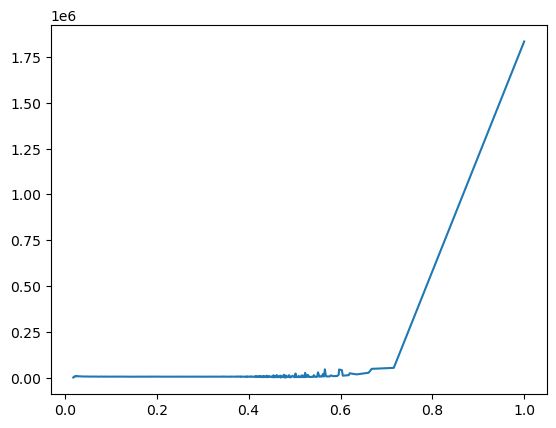

In [49]:
plt.plot(list(sorted_dict.keys()), list(sorted_dict.values()))

In [9]:
# confidence interval on precision per bin
from scipy.stats import binomtest
from sklearn.metrics import precision_score
import statsmodels.stats.proportion as smp

In [10]:
Counter(reg_df['label'])

Counter({1: 4332620, 0: 617488})

In [24]:
conf_starts = [0.0, 0.2, 0.4, 0.6, 0.8]
start_to_bin_df = {}
for c in conf_starts:
    start_to_bin_df[c] = reg_df[(reg_df['conf high'] > c) & (reg_df['conf high'] <= c + 0.2)] 

In [43]:
sources

Index(['CRISPR/CRISPRi', 'Computational Prediction', 'Decipher',
       'Decipher;Text Mining', 'Drug Screen', 'GenomeRNAi',
       'GenomeRNAi;Text Mining', 'High Throughput', 'Low Throughput',
       'Negative sampling', 'RNAi Screen', 'Synlethality',
       'Synlethality;Decipher', 'Synlethality;Text Mining', 'Text Mining',
       'Text Mining;Synlethality'],
      dtype='object', name='Source')

In [44]:
s_dict = {
    'CRISPR/CRISPRi' : {'CRISPR/CRISPRi'},
    'Other experimental' : {'Decipher', 'Drug Screen', 'GenomeRNAi', 
                            'High Throughput', 'Low Throughput', 'RNAi Screen', 'Synlethality','Synlethality;Decipher'},
    'Indirect / weak' : {'Computational Prediction', 'GenomeRNAi;Text Mining', 'Synlethality;Text Mining', 'Text Mining',
       'Text Mining;Synlethality'}
}

In [46]:
conf_bin_to_percentage_sl = {}
source_df = {s : {} for s in s_dict.keys()}
for c in tqdm(conf_starts):
    temp_df = start_to_bin_df[c]
    if len(temp_df) == 0:
        continue
    temp_df_sl = temp_df[temp_df['label'] == 1]
    for s in s_dict.keys():
        s_df = temp_df_sl[temp_df_sl['source'].isin(s_dict[s])]
        source_df[s][c] = len(s_df)/len(temp_df)
    conf_bin_to_percentage_sl[c] = len(temp_df_sl)/len(temp_df)

100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


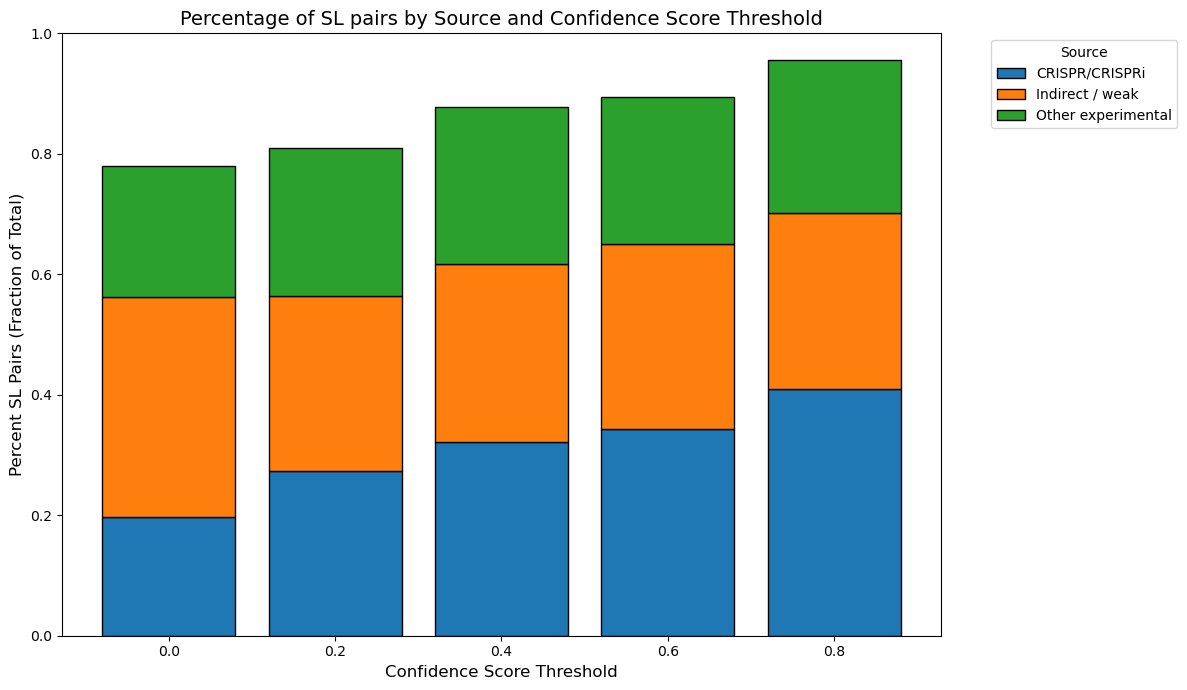

In [47]:
df = pd.DataFrame.from_dict(source_df, orient='index')
df.index.name = 'Source'
df = df.reset_index()

# Melt the DataFrame to long format for easier plotting
df_melted = df.melt(id_vars='Source', var_name='Conf_Score_Threshold', value_name='Percent_SL')

# Ensure the Conf_Score_Threshold is numeric for sorting and then convert to string for bar labels
df_melted['Conf_Score_Threshold'] = df_melted['Conf_Score_Threshold'].astype(float)
df_melted = df_melted.sort_values(by='Conf_Score_Threshold')
df_melted['Conf_Score_Threshold_str'] = df_melted['Conf_Score_Threshold'].astype(str)

# Prepare data for stacking
# Pivot the table to have Conf_Score_Threshold as index and Source as columns
df_pivot = df_melted.pivot(index='Conf_Score_Threshold_str', columns='Source', values='Percent_SL').fillna(0)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the bars
bottom = [0] * len(df_pivot.index)
sources = df_pivot.columns

for source in sources:
    ax.bar(
        df_pivot.index,
        df_pivot[source],
        bottom=bottom,
        label=source,
        edgecolor='black'
    )
    # Update the 'bottom' array for the next stack
    bottom = [bottom[i] + df_pivot[source].iloc[i] for i in range(len(bottom))]

# Customize the plot
ax.set_title('Percentage of SL pairs by Source and Confidence Score Threshold', fontsize=14)
ax.set_xlabel('Confidence Score Threshold', fontsize=12)
ax.set_ylabel('Percent SL Pairs (Fraction of Total)', fontsize=12)

# Set the x-axis tick labels to be sorted numerically
sorted_index = sorted(df_pivot.index.astype(float))
ax.set_xticks(df_pivot.index)
ax.set_xticklabels([str(x) for x in sorted_index])

ax.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim(0, 1)

# Save the plot
plt.savefig('figs_to_use/sources_stacked.pdf')

In [ ]:
c_to_p = {}
c_to_ci = {}

for c in conf_starts:
    t_df = start_to_bin_df[c]
    precision = precision_score(t_df['label'], t_df['pred'], pos_label=1, average='binary')
    
    print(f"Calculated Precision (for label=1): {precision:.4f}")
    
    TP = ((t_df['label'] == 1) & (t_df['pred'] == 1)).sum()
    FP = ((t_df['label'] == 0) & (t_df['pred'] == 1)).sum()
    n = TP + FP
    k = TP
    
    print(f"True Positives (k): {k}")
    print(f"Total Predicted Positives (n): {n}")
    
    if n > 0:
        lower_ci, upper_ci = smp.proportion_confint(
            count=k,
            nobs=n,
            alpha=0.05,
            method="wilson"
        )
    
        print("\n## 📈 Wilson Confidence Interval")
        print(f"Precision: {precision:.4f}")
        print(f"95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]")
    else:
        # Handle the case where there are no predicted positives (n=0),
        # in which case precision is undefined or often set to 1.0/0.0
        print("\nCannot compute Wilson CI: Total Predicted Positives (n) is 0.")
    c_to_p[c] = precision
    c_to_ci[c] = (lower_ci, upper_ci)

In [73]:
c_to_p

{0.0: 0.9580280904327576,
 0.1: 0.990090573667973,
 0.2: 0.9950657600543763,
 0.3: 0.9975301085788365,
 0.4: 0.99826458022998,
 0.5: 0.9989002989328253,
 0.6: 0.9984654603305837,
 0.7: 0.9998333472210649,
 0.8: 0.0,
 0.9: 0.9993332676659871}

In [35]:
reg_df

,gene 1,gene 2,label,pred,conf high,conf low,fold,patient,correct,tissue,gene_pairs,source
0,FKBP11,SLC22A1,0,0,0.330,0.002,0,ACH-001370,True,ovary,"(FKBP11, SLC22A1)",GenomeRNAi
1,FKBP11,SLC22A1,0,0,0.317,0.002,0,ACH-000305,True,lymph_node,"(FKBP11, SLC22A1)",GenomeRNAi
2,SMURF2,TP53,0,1,1.000,0.001,0,ACH-000836,False,salivary_gland,"(SMURF2, TP53)",Computational Prediction
3,SMURF2,TP53,0,1,0.477,0.001,0,ACH-001001,False,bone,"(SMURF2, TP53)",Computational Prediction
4,SMURF2,TP53,0,1,0.566,0.001,0,ACH-000896,False,urinary_tract,"(SMURF2, TP53)",Computational Prediction
...,...,...,...,...,...,...,...,...,...,...,...,...
4950103,AMPD2,LAD1,0,0,0.062,0.006,4,ACH-000778,True,upper_aerodigestive_tract,"(AMPD2, LAD1)",Negative sampling
4950104,AMPD2,LAD1,0,0,0.058,0.006,4,ACH-000118,True,ascites,"(AMPD2, LAD1)",Negative sampling
4950105,AMPD2,LAD1,0,0,0.100,0.004,4,ACH-000794,True,lymph_node,"(AMPD2, LAD1)",Negative sampling
4950106,AMPD2,LAD1,0,0,0.084,0.005,4,ACH-000865,True,oesophagus,"(AMPD2, LAD1)",Negative sampling


/tmp/ipykernel_1137138/5846586.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


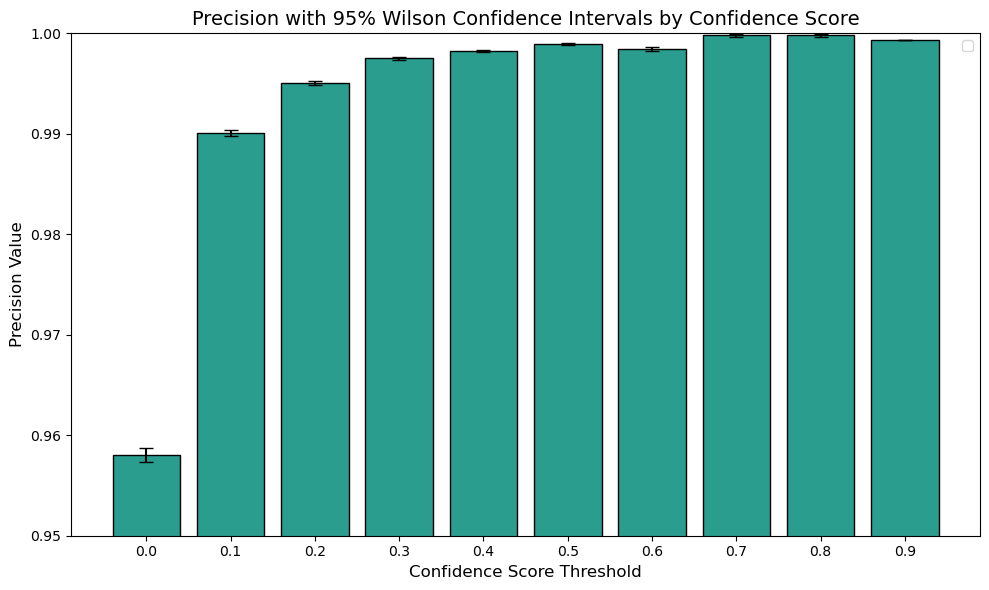

In [96]:
# 2. Correct the Inconsistent Data Point for 0.8
# The precision must be between Lower_CI and Upper_CI.
midpoint_08 = (c_to_ci[0.8][0] + c_to_ci[0.8][1]) / 2
c_to_p[0.8] = midpoint_08

# 3. Create and Prepare the DataFrame

# Create DataFrame from the precision data
df = pd.DataFrame.from_dict(c_to_p, orient='index', columns=['Precision'])
df.index.name = 'Conf_Score'

# Add the CI bounds
df['Lower_CI'] = [c_to_ci[c][0] for c in df.index]
df['Upper_CI'] = [c_to_ci[c][1] for c in df.index]
df = df.reset_index()

# Calculate Error Bar Lengths (needed for matplotlib yerr parameter)
# Lower Error: Precision - Lower CI
df['Lower_Error'] = df['Precision'] - df['Lower_CI']
# Upper Error: Upper CI - Precision
df['Upper_Error'] = df['Upper_CI'] - df['Precision']

# Create a 2xN array for the error bars, Transpose (.T) is crucial
yerr = df[['Lower_Error', 'Upper_Error']].values.T

# Sort the DataFrame by Confidence Score
df = df.sort_values(by='Conf_Score')

# 4. Generate the Bar Chart with Error Bars

plt.figure(figsize=(10, 6))

plt.bar(
    df['Conf_Score'].astype(str),  # Use string labels for x-axis
    df['Precision'],
    yerr=yerr,
    capsize=5,  # Width of the error bar caps
    color='#2A9D8F',
    edgecolor='black',
    # label='Precision'
)

# Customize the plot
plt.title('Precision with 95% Wilson Confidence Intervals by Confidence Score', fontsize=14)
plt.xlabel('Confidence Score Threshold', fontsize=12)
plt.ylabel('Precision Value', fontsize=12)
# Zoom in on the relevant range (0.95 to 1.0)
plt.ylim(0.95, 1.0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Save the plot (file name used in the previous step)
# plt.savefig('precision_bar_chart_with_ci.png')

plt.show()

In [81]:
sorted_df = reg_df[reg_df['conf high'] < 0.8]
sorted_df = sorted_df.sort_values(by='conf high', ascending=False)

In [83]:
fold_4 = reg_df[reg_df['fold'] == 4]

In [88]:
plot = _

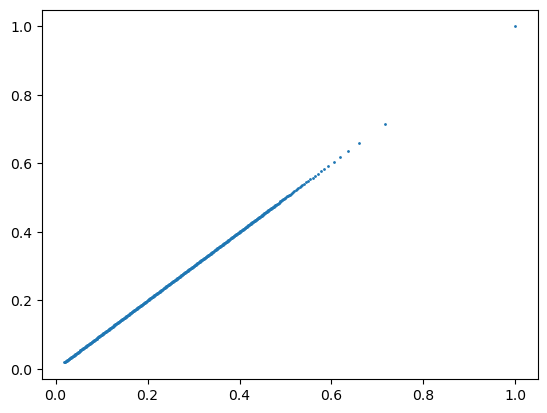

In [91]:
plt.scatter(plot, plot, s = 1)

In [38]:
Counter(reg_df['source'])

Counter({'CRISPR/CRISPRi': 1639750,
         'Computational Prediction': 1277639,
         'GenomeRNAi': 1042499,
         'Negative sampling': 432891,
         'Text Mining': 320384,
         'Decipher': 197729,
         'High Throughput': 9497,
         'RNAi Screen': 7262,
         'Decipher;Text Mining': 6043,
         'Low Throughput': 5067,
         'Synlethality': 4859,
         'Drug Screen': 4813,
         'Synlethality;Text Mining': 816,
         'Synlethality;Decipher': 747,
         'GenomeRNAi;Text Mining': 88,
         'Text Mining;Synlethality': 24})

In [100]:
gene_pairs = set(reg_df['gene_pairs'])

In [110]:
pos_preds = reg_df[reg_df['pred'] == 1]
neg_preds = reg_df[reg_df['pred'] == 0]

In [111]:
pos_pairs = set(pos_preds['gene_pairs'])
neg_pairs = set(neg_preds['gene_pairs'])

In [114]:
len(pos_pairs & neg_pairs)

4274

In [118]:
_ = pos_preds[pos_preds['gene_pairs'] == ('ARL2', 'SNRPC')] #657

In [ ]:
set(_['tissue'])

In [107]:
preds = set(temp['pred'])

In [108]:
preds

{0}